<a href="https://colab.research.google.com/github/korymath/public_notebooks/blob/master/Building_Equal_Size_Clusters_Kyle_Mathewson_Sept_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

random_state = 1017

# Generate and Visualize Data

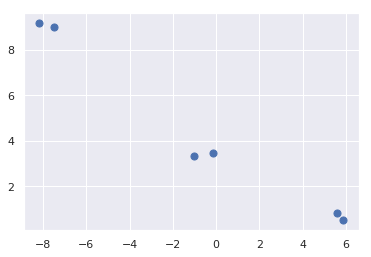

In [2]:
n_samples = 6
n_groups = 3
n_members = 2

# ensure that the calculus works out
assert n_groups * n_members == n_samples

X, y_true = make_blobs(n_samples=n_samples, centers=n_groups,
                       cluster_std=0.50, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
for x in X:
  print('{};'.format(x))

[-0.12260639  3.46400662];
[-8.17848874  9.18596168];
[-7.5051986   9.00890067];
[5.8667249  0.51736684];
[5.59627747 0.83136308];
[-1.01041072  3.34506264];


# K-Means Clustering

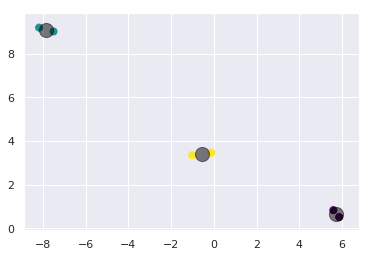

In [4]:
kmeans = KMeans(n_clusters=n_groups, n_init=100, max_iter=1000)
kmeans.fit(X)
labels = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [5]:
# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
except AssertionError as e:
  print('Unequal group sizes')

Group sizes: Counter({2: 2, 1: 2, 0: 2})


# (optional) Explicit Algorithm Details

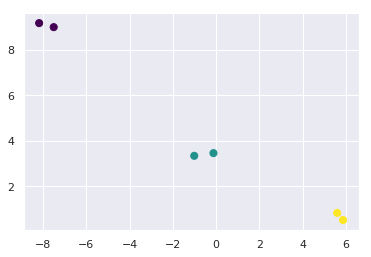

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_groups, rseed=random_state):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_groups]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_groups)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X=X, n_groups=n_groups)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

# Limitations of K-Means

1. Global optimum not guaranteed
2. n_groups must be selected beforehand
3. limited to linear cluster boundaries
4. slow for large n_samples
5. group sizes unequal

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


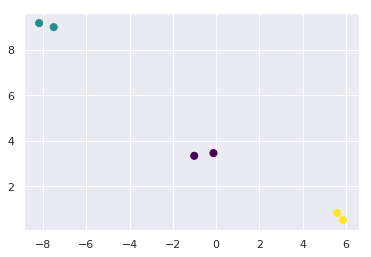

In [7]:
# To address limitation 1, we can increase n_init for different random
# starting points on centroids. We can also increase the number of iterations
# particularly if there is a small n_samples

# To address limitation 3, we can use spectral clustering

# use a kernel transformation to project the data into a higher dimension where 
# a linear separation is possible. 
# Allow k-means to discover non-linear boundaries.

from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=n_groups, affinity='nearest_neighbors',
                           assign_labels='kmeans', n_neighbors=n_members,
                           n_init=100, random_state=random_state)
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [8]:
# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
except AssertionError as e:
  print('Unequal group sizes')

Group sizes: Counter({0: 2, 1: 2, 2: 2})


# Contrained Group Size k-means Clustering

In [0]:
def average_data_distance_error(n_groups, memberships, distances):
    '''Calculate average distance between data in clusters.'''
    error = 0
    for k in range(n_groups):
        # indices of datapoints belonging to class k
        i = np.where(memberships == k)[0]
        error += np.mean(distances[tuple(np.meshgrid(i, i))])
    return error / n_groups
    
def cluster_equal_groups(data, n_groups=None, n_members=None, verbose=False):
    # equal-size clustering based on data exchanges between pairs of clusters
    
    # given two of three num_points, num_clusters, group_size 
    # the third is trivial to calculate
    n_samples, _ = data.shape
    if n_members is None and n_groups is not None:
        n_members = n_samples // n_groups
    elif n_groups is None and n_members is not None:
        n_groups = n_samples // n_members
    else:
        raise Exception('must specify either n_members or n_groups')
        
    # distance matrix
    distances = squareform(pdist(data)) 
    # print(distances)
    
    # Random initial membership
    # np.random.seed(random_state)
    # memberships = np.random.permutation(n_samples) % n_groups

    # Initial membership
    kmeans = KMeans(n_clusters=n_groups, n_init=100, max_iter=1000)
    kmeans.fit(data)
    memberships = kmeans.predict(data)
    
    current_err = average_data_distance_error(n_groups, memberships, distances)
    # print(n_groups, memberships)
    t = 1
    while True:
        past_err = current_err
        for a in range(n_samples):
            for b in range(a):
                # exchange membership
                memberships[a], memberships[b] = memberships[b], memberships[a] 
                # calculate new error
                test_err = average_data_distance_error(n_groups, memberships, distances)
                if verbose:
                  print("{}: {}<->{} E={}".format(t, a, b, current_err))
                if test_err < current_err:
                    current_err = test_err
                else:
                    # put them back
                    memberships[a], memberships[b] = memberships[b], memberships[a]  
        if past_err == current_err:
            break
        t += 1    
    return memberships

Group sizes: Counter({1: 5, 5: 4, 0: 4, 3: 4, 4: 4, 2: 4, 6: 4, 7: 3})
Unequal group sizes
Equal group memberships found in 0.43 s


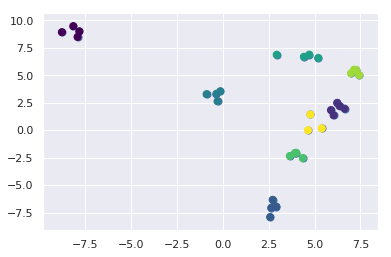

In [61]:
import time

n_samples = 32
n_groups = 8
n_members = n_samples // n_groups

# ensure that the calculus works out
assert n_groups * n_members == n_samples

X, y_true = make_blobs(n_samples=n_samples, 
                       centers=n_groups,
                       cluster_std=0.50, 
                       random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], s=50);

t0 = time.time()
labels = cluster_equal_groups(X, n_groups=n_groups, verbose=False)
t1 = time.time()

# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
  print('Success, group sizes are equal!')
except AssertionError as e:
  print('Unequal group sizes')

print('Equal group memberships found in {} s'.format(round(t1-t0, 2)))

# Plot the memberships
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [14]:
nx, ny = 4, 8
xs = np.linspace(0, 1, nx)
ys = np.linspace(0, 1, ny)
x, y = np.meshgrid(xs, ys) + np.random.normal(scale=0.01, size=(ny, nx))
print(x.shape, y.shape)

(8, 4) (8, 4)


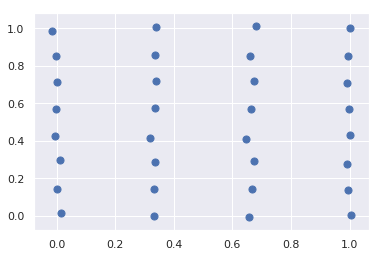

In [15]:
X = np.zeros(shape=(len(x.flatten()), 2))
X[:, 0] = x.flatten()
X[:, 1] = y.flatten()
plt.scatter(X[:, 0], X[:, 1], s=50);

0.5129219103723708
1.0560341900939756
1.6782731464563996
2.2412840002833647
0.5044357388169038
1.0749051213709562
1.6971440777333802
2.2601549315603453
0.520734656278706
1.0638469360003109
1.6860858923627349
2.3100834221753486
0.5129219103723708
1.064301348880275
1.686540305242699
2.2737218199466445
0.5626893052131928
1.1058015849347977
1.7193309065736218
2.282341760400587
0.5129219103723708
1.1048282966528058
1.7002617042983144
2.26327255812528
0.5129219103723708
1.0560341900939756
1.654591908553222
2.21596041739965
0.49219676790430245
1.0353090476259075
1.6338667660851538
2.2023619380131665
0.5044357388169038
1.0604412360079898
1.658998954467236
2.227494126395249
0.520734656278706
1.0638469360003109
1.6578398204791516
2.2263349924071645
0.5626893052131928
1.1058015849347977
1.704359303394044
2.3283568332066578
0.49219676790430245
1.08379516456643
1.6823528830256764
2.1813512550333005
0.49219676790430245
1.0626661504583548
1.661223868917601
2.175725010736106
0.49219676790430245
1.0955

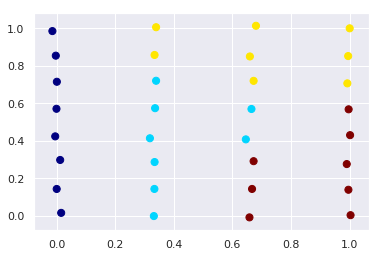

In [16]:
labels = cluster_equal_groups(X, n_groups=4, verbose=False)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='jet');

# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
except AssertionError as e:
  print('Unequal group sizes')

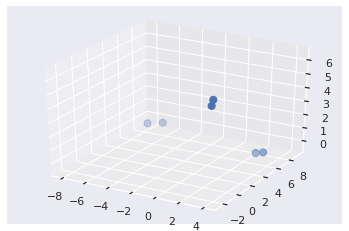

In [17]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

X, y_true = make_blobs(n_samples=n_samples, 
                       centers=n_groups,
                       n_features=3,
                       cluster_std=0.50, 
                       random_state=random_state)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=50)

In [18]:
labels = cluster_equal_groups(X, n_groups=n_groups)

5.557238021921267
10.519879639929382
19.07234490101513
0.6014332092310811
5.564074827239195
10.983717319772545
0.6014332092310811
5.564074827239195
10.983717319772545
5.098881344007397
10.06152296201551
18.808657620816327
8.747134658800817
13.709776276808931
18.808657620816327
0.6014332092310811
5.564074827239195
10.983717319772545
8.552465261085748
13.515106879093862
19.07234490101513
8.833531282766318
14.574296616987947
19.9939391095213
0.6014332092310811
1.3251050434809049
1.5622196985565977
8.644365537839214
9.368037372089038
18.115172030889855
0.6014332092310811
1.3251050434809049
1.5622196985565977
6.18062106434873
11.279502408356127
11.51661706343182
0.6014332092310811
1.3251050434809049
1.5622196985565977
5.7407653342216305
11.298003356142898
11.535118011218591
0.6014332092310811
6.021075701764432
10.983717319772545
0.6014332092310811
6.08411180005428
10.989709551255777
5.557238021921267
11.298003356142898
11.535118011218591
0.6014332092310811
1.3251050434809049
1.5622196985565

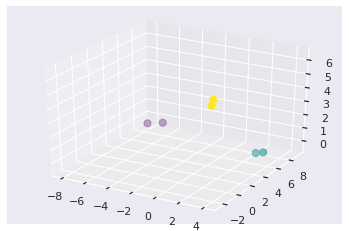

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, s=50, cmap='viridis');

In [20]:
np.random.permutation(n_samples) % 4

array([3, 0, 1, 1, 0, 2])

In [22]:
distances = squareform(pdist(X))
distances

array([[ 0.        , 10.19776269,  1.20286642, 17.10493052, 17.28873108,
        11.48153067],
       [10.19776269,  0.        , 11.11447604, 10.83928499, 10.96535718,
         1.44734367],
       [ 1.20286642, 11.11447604,  0.        , 17.49426932, 17.66706257,
        12.36124213],
       [17.10493052, 10.83928499, 17.49426932,  0.        ,  0.47422931,
         9.8111955 ],
       [17.28873108, 10.96535718, 17.66706257,  0.47422931,  0.        ,
         9.92528324],
       [11.48153067,  1.44734367, 12.36124213,  9.8111955 ,  9.92528324,
         0.        ]])

In [23]:
distances[np.meshgrid((0,1), (0,1))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([[ 0.        , 10.19776269],
       [10.19776269,  0.        ]])

In [24]:
np.mean(distances[tuple(np.meshgrid([0,1], [0,1]))])

5.098881344007397

In [25]:
distances[tuple(np.meshgrid([2,3], [2,3]))]

array([[ 0.        , 17.49426932],
       [17.49426932,  0.        ]])

In [26]:
np.meshgrid([1,2,3],[1,2,3])
# distances[tuple(np.meshgrid([1,2,3],[1,2,3]))]

[array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]), array([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])]

In [27]:
memberships = np.random.permutation(n_samples) % n_groups
np.where(memberships == 3)[0]

array([], dtype=int64)

In [28]:
tuple(np.meshgrid([1,2,3], [1,2,3])[0])

(array([1, 2, 3]), array([1, 2, 3]), array([1, 2, 3]))

In [29]:
distances[np.meshgrid([1,2,3], [1,2,3])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([[ 0.        , 11.11447604, 10.83928499],
       [11.11447604,  0.        , 17.49426932],
       [10.83928499, 17.49426932,  0.        ]])

In [0]:
"""Equal Groups K-Means clustering utlizing the scikit-learn api and related
utilities.
BSD 3-clause "New" or "Revised" License
version 0.17.1
"""


import warnings

import numpy as np
import scipy.sparse as sp

from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.cluster import k_means_
from sklearn.cluster import _k_means
from joblib import Parallel
from joblib import delayed
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.extmath import row_norms, squared_norm
from sklearn.utils.sparsefuncs import mean_variance_axis
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import as_float_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import FLOAT_DTYPES



class EqualGroupsKMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    """Equal Groups K-Means clustering
    90 percent of this is the Kmeans implmentations with the equal groups logic
    located in `_labels_inertia_precompute_dense()` which follows the steps laid
    out in the Elki Same-size k-Means Variation tutorial.
    https://elki-project.github.io/tutorial/same-size_k_means
    Please note that this implementation only works in scikit-learn 17.X as later
    versions having breaking changes to this implementation.
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    max_iter : int, default: 300
        Maximum number of iterations of the k-means algorithm for a
        single run.
    n_init : int, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
    init : {'k-means++', 'random' or an ndarray}
        Method for initialization, defaults to 'k-means++':
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': choose k observations (rows) at random from data for
        the initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centers.
    precompute_distances : {'auto', True, False}
        Precompute distances (faster but takes more memory).
        'auto' : do not precompute distances if n_samples * n_clusters > 12
        million. This corresponds to about 100MB overhead per job using
        double precision.
        True : always precompute distances
        False : never precompute distances
    tol : float, default: 1e-4
        Relative tolerance with regards to inertia to declare convergence
    n_jobs : int
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For n_jobs below -1,
        (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one
        are used.
    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.
    verbose : int, default 0
        Verbosity mode.
    copy_x : boolean, default True
        When pre-computing distances it is more numerically accurate to center
        the data first.  If copy_x is True, then the original data is not
        modified.  If False, the original data is modified, and put back before
        the function returns, but small numerical differences may be introduced
        by subtracting and then adding the data mean.
    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Coordinates of cluster centers
    labels_ :
        Labels of each point
    inertia_ : float
        Sum of distances of samples to their closest cluster center.
    Notes
    ------
    The k-means problem is solved using Lloyd's algorithm.
    The average complexity is given by O(k n T), were n is the number of
    samples and T is the number of iteration.
    The worst case complexity is given by O(n^(k+2/p)) with
    n = n_samples, p = n_features. (D. Arthur and S. Vassilvitskii,
    'How slow is the k-means method?' SoCG2006)
    In practice, the k-means algorithm is very fast (one of the fastest
    clustering algorithms available), but it falls in local minima. That's why
    it can be useful to restart it several times.
    See also
    --------
    MiniBatchKMeans:
        Alternative online implementation that does incremental updates
        of the centers positions using mini-batches.
        For large scale learning (say n_samples > 10k) MiniBatchKMeans is
        probably much faster to than the default batch implementation.
    """

    def __init__(self, n_clusters=8, init='k-means++', n_init=10, max_iter=300,
                 tol=1e-4, precompute_distances='auto',
                 verbose=0, random_state=None, copy_x=True, n_jobs=1):

        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.precompute_distances = precompute_distances
        self.n_init = n_init
        self.verbose = verbose
        self.random_state = random_state
        self.copy_x = copy_x
        self.n_jobs = n_jobs

    def _check_fit_data(self, X):
        """Verify that the number of samples given is larger than k"""
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        if X.shape[0] < self.n_clusters:
            raise ValueError("n_samples=%d should be >= n_clusters=%d" % (
                X.shape[0], self.n_clusters))
        return X

    def _check_test_data(self, X):
        X = check_array(X, accept_sparse='csr', dtype=FLOAT_DTYPES,
                        warn_on_dtype=True)
        n_samples, n_features = X.shape
        expected_n_features = self.cluster_centers_.shape[1]
        if not n_features == expected_n_features:
            raise ValueError("Incorrect number of features. "
                             "Got %d features, expected %d" % (
                                 n_features, expected_n_features))

        return X

    def fit(self, X, y=None):
        """Compute k-means clustering.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        """
        random_state = check_random_state(self.random_state)
        X = self._check_fit_data(X)

        self.cluster_centers_, self.labels_, self.inertia_, self.n_iter_ = \
            k_means(
                X, n_clusters=self.n_clusters, init=self.init,
                n_init=self.n_init, max_iter=self.max_iter,
                verbose=self.verbose, return_n_iter=True,
                precompute_distances=self.precompute_distances,
                tol=self.tol, random_state=random_state, copy_x=self.copy_x,
                n_jobs=self.n_jobs)
        return self

    def fit_predict(self, X, y=None):
        """Compute cluster centers and predict cluster index for each sample.
        Convenience method; equivalent to calling fit(X) followed by
        predict(X).
        """
        return self.fit(X).labels_

    def fit_transform(self, X, y=None):
        """Compute clustering and transform X to cluster-distance space.
        Equivalent to fit(X).transform(X), but more efficiently implemented.
        """
        # Currently, this just skips a copy of the data if it is not in
        # np.array or CSR format already.
        # XXX This skips _check_test_data, which may change the dtype;
        # we should refactor the input validation.
        X = self._check_fit_data(X)
        return self.fit(X)._transform(X)

    def transform(self, X, y=None):
        """Transform X to a cluster-distance space.
        In the new space, each dimension is the distance to the cluster
        centers.  Note that even if X is sparse, the array returned by
        `transform` will typically be dense.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            New data to transform.
        Returns
        -------
        X_new : array, shape [n_samples, k]
            X transformed in the new space.
        """
        check_is_fitted(self, 'cluster_centers_')

        X = self._check_test_data(X)
        return self._transform(X)

    def _transform(self, X):
        """guts of transform method; no input validation"""
        return euclidean_distances(X, self.cluster_centers_)

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.
        In the vector quantization literature, `cluster_centers_` is called
        the code book and each value returned by `predict` is the index of
        the closest code in the code book.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            New data to predict.
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        check_is_fitted(self, 'cluster_centers_')

        X = self._check_test_data(X)
        x_squared_norms = row_norms(X, squared=True)
        return _labels_inertia(X, x_squared_norms, self.cluster_centers_)[0]

    def score(self, X, y=None):
        """Opposite of the value of X on the K-means objective.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            New data.
        Returns
        -------
        score : float
            Opposite of the value of X on the K-means objective.
        """
        check_is_fitted(self, 'cluster_centers_')

        X = self._check_test_data(X)
        x_squared_norms = row_norms(X, squared=True)
        return -_labels_inertia(X, x_squared_norms, self.cluster_centers_)[1]



def k_means(X, n_clusters, init='k-means++', precompute_distances='auto',
            n_init=10, max_iter=300, verbose=False,
            tol=1e-4, random_state=None, copy_x=True, n_jobs=1,
            return_n_iter=False):
    """K-means clustering algorithm.
    Read more in the :ref:`User Guide <k_means>`.
    Parameters
    ----------
    X : array-like or sparse matrix, shape (n_samples, n_features)
        The observations to cluster.
    n_clusters : int
        The number of clusters to form as well as the number of
        centroids to generate.
    max_iter : int, optional, default 300
        Maximum number of iterations of the k-means algorithm to run.
    n_init : int, optional, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
    init : {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++':
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': generate k centroids from a Gaussian with mean and
        variance estimated from the data.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centers.
        If a callable is passed, it should take arguments X, k and
        and a random state and return an initialization.
    precompute_distances : {'auto', True, False}
        Precompute distances (faster but takes more memory).
        'auto' : do not precompute distances if n_samples * n_clusters > 12
        million. This corresponds to about 100MB overhead per job using
        double precision.
        True : always precompute distances
        False : never precompute distances
    tol : float, optional
        The relative increment in the results before declaring convergence.
    verbose : boolean, optional
        Verbosity mode.
    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.
    copy_x : boolean, optional
        When pre-computing distances it is more numerically accurate to center
        the data first.  If copy_x is True, then the original data is not
        modified.  If False, the original data is modified, and put back before
        the function returns, but small numerical differences may be introduced
        by subtracting and then adding the data mean.
    n_jobs : int
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For n_jobs below -1,
        (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one
        are used.
    return_n_iter : bool, optional
        Whether or not to return the number of iterations.
    Returns
    -------
    centroid : float ndarray with shape (k, n_features)
        Centroids found at the last iteration of k-means.
    label : integer ndarray with shape (n_samples,)
        label[i] is the code or index of the centroid the
        i'th observation is closest to.
    inertia : float
        The final value of the inertia criterion (sum of squared distances to
        the closest centroid for all observations in the training set).
    best_n_iter: int
        Number of iterations corresponding to the best results.
        Returned only if `return_n_iter` is set to True.
    """
    if n_init <= 0:
        raise ValueError("Invalid number of initializations."
                         " n_init=%d must be bigger than zero." % n_init)
    random_state = check_random_state(random_state)

    if max_iter <= 0:
        raise ValueError('Number of iterations should be a positive number,'
                         ' got %d instead' % max_iter)

    best_inertia = np.infty
    X = as_float_array(X, copy=copy_x)
    tol = _tolerance(X, tol)

    # If the distances are precomputed every job will create a matrix of shape
    # (n_clusters, n_samples). To stop KMeans from eating up memory we only
    # activate this if the created matrix is guaranteed to be under 100MB. 12
    # million entries consume a little under 100MB if they are of type double.
    if precompute_distances == 'auto':
        n_samples = X.shape[0]
        precompute_distances = (n_clusters * n_samples) < 12e6
    elif isinstance(precompute_distances, bool):
        pass
    else:
        raise ValueError("precompute_distances should be 'auto' or True/False"
                         ", but a value of %r was passed" %
                         precompute_distances)

    # subtract of mean of x for more accurate distance computations
    if not sp.issparse(X) or hasattr(init, '__array__'):
        X_mean = X.mean(axis=0)
    if not sp.issparse(X):
        # The copy was already done above
        X -= X_mean

    if hasattr(init, '__array__'):
        init = check_array(init, dtype=np.float64, copy=True)
        _validate_center_shape(X, n_clusters, init)

        init -= X_mean
        if n_init != 1:
            warnings.warn(
                'Explicit initial center position passed: '
                'performing only one init in k-means instead of n_init=%d'
                % n_init, RuntimeWarning, stacklevel=2)
            n_init = 1

    # precompute squared norms of data points
    x_squared_norms = row_norms(X, squared=True)

    best_labels, best_inertia, best_centers = None, None, None
    if n_jobs == 1:
        # For a single thread, less memory is needed if we just store one set
        # of the best results (as opposed to one set per run per thread).
        for it in range(n_init):
            # run a k-means once
            labels, inertia, centers, n_iter_ = _kmeans_single(
                X, n_clusters, max_iter=max_iter, init=init, verbose=verbose,
                precompute_distances=precompute_distances, tol=tol,
                x_squared_norms=x_squared_norms, random_state=random_state)
            # determine if these results are the best so far
            if best_inertia is None or inertia < best_inertia:
                best_labels = labels.copy()
                best_centers = centers.copy()
                best_inertia = inertia
                best_n_iter = n_iter_
    else:
        # parallelisation of k-means runs
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=0)(
            delayed(_kmeans_single)(X, n_clusters, max_iter=max_iter,
                                    init=init, verbose=verbose, tol=tol,
                                    precompute_distances=precompute_distances,
                                    x_squared_norms=x_squared_norms,
                                    # Change seed to ensure variety
                                    random_state=seed)
            for seed in seeds)
        # Get results with the lowest inertia
        labels, inertia, centers, n_iters = zip(*results)
        best = np.argmin(inertia)
        best_labels = labels[best]
        best_inertia = inertia[best]
        best_centers = centers[best]
        best_n_iter = n_iters[best]

    if not sp.issparse(X):
        if not copy_x:
            X += X_mean
        best_centers += X_mean

    if return_n_iter:
        return best_centers, best_labels, best_inertia, best_n_iter
    else:
        return best_centers, best_labels, best_inertia


def _kmeans_single(X, n_clusters, x_squared_norms, max_iter=300,
                   init='k-means++', verbose=False, random_state=None,
                   tol=1e-4, precompute_distances=True):
    """A single run of k-means, assumes preparation completed prior.
    Parameters
    ----------
    X: array-like of floats, shape (n_samples, n_features)
        The observations to cluster.
    n_clusters: int
        The number of clusters to form as well as the number of
        centroids to generate.
    max_iter: int, optional, default 300
        Maximum number of iterations of the k-means algorithm to run.
    init: {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++':
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': generate k centroids from a Gaussian with mean and
        variance estimated from the data.
        If an ndarray is passed, it should be of shape (k, p) and gives
        the initial centers.
        If a callable is passed, it should take arguments X, k and
        and a random state and return an initialization.
    tol: float, optional
        The relative increment in the results before declaring convergence.
    verbose: boolean, optional
        Verbosity mode
    x_squared_norms: array
        Precomputed x_squared_norms.
    precompute_distances : boolean, default: True
        Precompute distances (faster but takes more memory).
    random_state: integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.
    Returns
    -------
    centroid: float ndarray with shape (k, n_features)
        Centroids found at the last iteration of k-means.
    label: integer ndarray with shape (n_samples,)
        label[i] is the code or index of the centroid the
        i'th observation is closest to.
    inertia: float
        The final value of the inertia criterion (sum of squared distances to
        the closest centroid for all observations in the training set).
    n_iter : int
        Number of iterations run.
    """
    random_state = check_random_state(random_state)

    best_labels, best_inertia, best_centers = None, None, None
    # init
    centers = k_means_._init_centroids(X, n_clusters, init, random_state=random_state,
                              x_squared_norms=x_squared_norms)
    if verbose:
        print("Initialization complete")

    # Allocate memory to store the distances for each sample to its
    # closer center for reallocation in case of ties
    distances = np.zeros(shape=(X.shape[0],), dtype=np.float64)

    # iterations
    for i in range(max_iter):
        centers_old = centers.copy()
        # labels assignment is also called the E-step of EM
        labels, inertia = \
            _labels_inertia(X, x_squared_norms, centers,
                            precompute_distances=precompute_distances,
                            distances=distances)

        # computation of the means is also called the M-step of EM
        if sp.issparse(X):
            centers = _k_means._centers_sparse(X, labels, n_clusters,
                                               distances)
        else:
            centers = _k_means._centers_dense(X, np.ones(len(X)), labels, n_clusters, distances)

        if verbose:
            print("Iteration %2d, inertia %.3f" % (i, inertia))

        if best_inertia is None or inertia < best_inertia:
            best_labels = labels.copy()
            best_centers = centers.copy()
            best_inertia = inertia

        shift = squared_norm(centers_old - centers)
        if shift <= tol:
            if verbose:
                print("Converged at iteration %d" % i)

            break

    if shift > 0:
        # rerun E-step in case of non-convergence so that predicted labels
        # match cluster centers
        best_labels, best_inertia = \
            _labels_inertia(X, x_squared_norms, best_centers,
                            precompute_distances=precompute_distances,
                            distances=distances)

    return best_labels, best_inertia, best_centers, i + 1


def _validate_center_shape(X, n_centers, centers):
    """Check if centers is compatible with X and n_centers"""
    if len(centers) != n_centers:
        raise ValueError('The shape of the initial centers (%s) '
                         'does not match the number of clusters %i'
                         % (centers.shape, n_centers))
    if centers.shape[1] != X.shape[1]:
        raise ValueError(
            "The number of features of the initial centers %s "
            "does not match the number of features of the data %s."
            % (centers.shape[1], X.shape[1]))


def _tolerance(X, tol):
    """Return a tolerance which is independent of the dataset"""
    if sp.issparse(X):
        variances = mean_variance_axis(X, axis=0)[1]
    else:
        variances = np.var(X, axis=0)
    return np.mean(variances) * tol


def _labels_inertia(X, x_squared_norms, centers,
                    precompute_distances=True, distances=None):
    """E step of the K-means EM algorithm.
    Compute the labels and the inertia of the given samples and centers.
    This will compute the distances in-place.
    Parameters
    ----------
    X: float64 array-like or CSR sparse matrix, shape (n_samples, n_features)
        The input samples to assign to the labels.
    x_squared_norms: array, shape (n_samples,)
        Precomputed squared euclidean norm of each data point, to speed up
        computations.
    centers: float64 array, shape (k, n_features)
        The cluster centers.
    precompute_distances : boolean, default: True
        Precompute distances (faster but takes more memory).
    distances: float64 array, shape (n_samples,)
        Pre-allocated array to be filled in with each sample's distance
        to the closest center.
    Returns
    -------
    labels: int array of shape(n)
        The resulting assignment
    inertia : float
        Sum of distances of samples to their closest cluster center.
    """
    n_samples = X.shape[0]
    # set the default value of centers to -1 to be able to detect any anomaly
    # easily
    labels = -np.ones(n_samples, np.int32)
    if distances is None:
        distances = np.zeros(shape=(0,), dtype=np.float64)
    # distances will be changed in-place
    if sp.issparse(X):
        inertia = k_means_._k_means._assign_labels_csr(
            X, x_squared_norms, centers, labels, distances=distances)
    else:
        if precompute_distances:
            return _labels_inertia_precompute_dense(X, x_squared_norms,
                                                    centers, distances)
        inertia = k_means_._k_means._assign_labels_array(
            X, x_squared_norms, centers, labels, distances=distances)
    return labels, inertia



def _labels_inertia_precompute_dense(X, x_squared_norms, centers, distances):
    """Compute labels and inertia using a full distance matrix.
    This will overwrite the 'distances' array in-place.
    Parameters
    ----------
    X : numpy array, shape (n_sample, n_features)
        Input data.
    x_squared_norms : numpy array, shape (n_samples,)
        Precomputed squared norms of X.
    centers : numpy array, shape (n_clusters, n_features)
        Cluster centers which data is assigned to.
    distances : numpy array, shape (n_samples,)
        Pre-allocated array in which distances are stored.
    Returns
    -------
    labels : numpy array, dtype=np.int, shape (n_samples,)
        Indices of clusters that samples are assigned to.
    inertia : float
        Sum of distances of samples to their closest cluster center.
    """
    n_samples = X.shape[0]
    k = centers.shape[0]
    all_distances = euclidean_distances(centers, X, x_squared_norms,
                                        squared=True)
    labels = np.empty(n_samples, dtype=np.int32)
    labels.fill(-1)
    mindist = np.empty(n_samples)
    mindist.fill(np.infty)


    n_samples = X.shape[0]
    k = centers.shape[0]
    max_cluster_size = get_clusters_size(n_samples, k)

    labels, mindist = initial_assignment(labels, mindist, n_samples, all_distances, max_cluster_size)
    all_points = np.arange(n_samples)

    for point in all_points:
        for point_dist in get_best_point_distances(point, all_distances):
            cluster_id, point_dist = point_dist
            # initial assignment
            if not is_cluster_full(cluster_id, max_cluster_size, labels):
                labels[point] = cluster_id
                mindist[point] = point_dist
                break

    # refinement of clustering
    transfer_list = []
    best_mindist = mindist.copy()
    best_labels = labels.copy()
    # sort all of the points from largest distance to smallest
    points_by_high_distance = np.argsort(mindist)[::-1]
    for point in points_by_high_distance:
        point_cluster = labels[point]

        # see if there is an opening on the best cluster for this point
        cluster_id, point_dist = get_best_cluster_for_point(point, all_distances)
        if not is_cluster_full(cluster_id, max_cluster_size, labels) and point_cluster != cluster_id:
            labels[point] = cluster_id
            mindist[point] = point_dist
            best_labels = labels.copy()
            best_mindist = mindist.copy()
            continue # on to the next point

        for swap_candidate in transfer_list:
            cand_cluster = labels[swap_candidate]
            if point_cluster != cand_cluster:

                # get the current dist of swap candidate
                cand_distance = mindist[swap_candidate]

                # get the potential dist of point
                point_distance = all_distances[cand_cluster, point]

                # compare
                if point_distance < cand_distance:

                    labels[point] = cand_cluster
                    mindist[point] = all_distances[cand_cluster, point]

                    labels[swap_candidate] = point_cluster
                    mindist[swap_candidate] = all_distances[point_cluster, swap_candidate]

                    if np.absolute(mindist).sum() <  np.absolute(best_mindist).sum():
                        # update the labels since the transfer was a success
                        best_labels = labels.copy()
                        best_mindist = mindist.copy()
                        break

                    else:
                        # reset since the transfer was not a success
                        labels = best_labels.copy()
                        mindist = best_mindist.copy()

        transfer_list.append(point)

    if n_samples == distances.shape[0]:
        # distances will be changed in-place
        distances[:] = mindist
    inertia = best_mindist.sum()

    return best_labels, inertia

def get_best_cluster_for_point(point, all_distances):
    """Gets the best cluster by distance for a point
    Argument
    --------
    point : int
        the point index
    Returns
    --------
    tuple
        (cluster_id, distance_from_cluster_center)
    """

    sorted_distances = get_best_point_distances(point, all_distances)
    cluster_id, point_dist = sorted_distances[0]
    return cluster_id, point_dist

def get_best_point_distances(point, all_distances):
    """Gets a sorted by best distance of clusters
    Argument
    --------
    point : int
        the point index
    Returns
    --------
    list of tuples sorted by point_dist
        example: [(cluster_id, point_dist), (cluster_id, point_dist)]
    """
    points_distances = all_distances[:, point]
    sorted_points = sort_adjust_row(points_distances)
    return sorted_points

def sort_adjust_row(points_distances):
    "Sorts the points row from smallest distance to lowest distance"
    return sorted([(cluster_id, point_dist) for cluster_id, point_dist in enumerate(points_distances)], key=lambda x: x[1])

def is_cluster_full(cluster_id, max_cluster_size, labels):
    """Determies in a cluster is full"""
    cluster_count = len(np.where(labels==cluster_id)[0])
    is_full = cluster_count >= max_cluster_size
    return is_full

def get_clusters_size(n_samples, n_clusters):
    """Gets the number of members per cluster for equal groups kmeans"""
    return (n_samples + n_clusters - 1) // n_clusters

def initial_assignment(labels, mindist, n_samples, all_distances, max_cluster_size):
    """Initial assignment of labels and mindist"""
    all_points = np.arange(n_samples)
    for point in all_points:
        for point_dist in get_best_point_distances(point, all_distances):
            cluster_id, point_dist = point_dist
            # initial assignment
            if not is_cluster_full(cluster_id, max_cluster_size, labels):
                labels[point] = cluster_id
                mindist[point] = point_dist
                break
    return labels, mindist

In [83]:
X

array([[ 0.01340618,  2.65630696],
       [ 6.41950857, -1.21673789],
       [ 9.07234939, -8.33739761],
       [ 6.67446005, -8.88819293],
       [-0.52047595,  3.32087744],
       [ 5.74099843,  2.69722495],
       [ 0.56438521, -2.67918113],
       [ 7.57183781, -1.72754606],
       [ 4.45176062,  7.0031715 ],
       [ 2.40437192, -7.17112161],
       [ 5.78679544, -8.61015198],
       [ 9.9487503 ,  8.64364293],
       [ 5.94380071, -8.01532796],
       [-8.0736419 ,  8.25636737],
       [ 3.06830833, -6.94543564],
       [ 6.85962437, -1.04786717],
       [ 4.76480353,  5.69088557],
       [ 2.52923302, -0.60178641],
       [ 6.23362982, -8.57917432],
       [ 3.66742286,  6.96514907],
       [ 2.89125228, -1.70189157],
       [ 2.67867637, -8.14405112],
       [ 7.36655782, -0.20509004],
       [ 3.75389017,  6.71855943],
       [ 6.66864325,  4.86577337],
       [-7.3434464 ,  8.76255337],
       [-0.16515142,  2.84311089],
       [ 2.81938817, -0.73771858],
       [ 3.86326311,

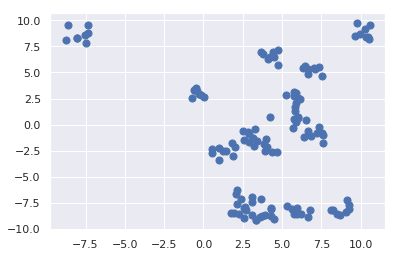

In [84]:
n_samples = 128
n_groups = 16
n_members = 8

# ensure that the calculus works out
assert n_groups * n_members == n_samples

X, y_true = make_blobs(n_samples=n_samples, centers=n_groups,
                       cluster_std=0.50, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [85]:
clf = EqualGroupsKMeans(n_clusters=n_groups)

clf.fit(X)

labels = clf.labels_

# test the group size, AssertionError on failure
C = Counter(labels)
print('Group sizes: {}'.format(C))

try:
  assert list(C.values()) == [n_members] * n_groups
  print('Successfully found equal group sizes.')
except AssertionError as e:
  print('Unequal group sizes')
  print(C.values())

Group sizes: Counter({1: 8, 8: 8, 6: 8, 14: 8, 11: 8, 0: 8, 13: 8, 15: 8, 5: 8, 4: 8, 12: 8, 9: 8, 7: 8, 10: 8, 3: 8, 2: 8})
Successfully found equal group sizes.
